In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

In [2]:
# Import local classes
# Import local classes
import sys
sys.path.append(r'../../src/')

import bivariate.class_copula

### 1. Wind set-up
$$S = C_2 * \frac{u^2}{g*d}*F$$

In [3]:
def wind_set_up(u,d,F=3000, C2 = 4.0e-6):
    """
    This function calculates the wind set-up from the wind speed and average depth

    Parameters
    ----------
    u : float
        [m/s] Wind speed
    d : float
        [m] Average depth over fetch length
    F : float
        [m] Fetch length
    C2 : float, optional
        [-] Empirical constant, between 3.5e-6 and 4.0e-6, default is 4.0e-6
    
    Returns
    -------
    S : float
        [m] Wind set-up at toe of the dike
    """

    g = 9.81
    S = C2 * (u**2)/(g*d) * F  
    return S 

### 2. Run-up level
$$Ru_{2\%} = 8H_s*tan(\alpha)$$

In [4]:
def run_up_level(Hs,alpha):
    import numpy as np
    """
    This function calculates the run-up level from the significant wave height

    Parameters
    ----------
    Hs : float
        [m] Significant wave height
    alpha : float
        [degrees] Angle of the slope of the toe of dike
    
    Returns
    -------
    Ru2 : float
        [m] Run-up level, exceeded by 2% of the waves
    """
    # Since numpy works with radians, we need to convert the angle to radians
    alpha_radians = np.radians(alpha)

    Ru2 = 8*Hs*np.tan(alpha_radians)
    return Ru2


### 3. Average water depth
$$d_{average,fetch} = h_{offshore} - Z_{bed}$$

### 4. Water level at dike
$$d_{waterlevel,dike} = d_{average,fetch} + Ru_{2\%} + S $$ 

### B. Determine statistical properties of Random Variables

In [5]:
#### Add background information!!!!

### B.1. Plotting distributions


In [6]:
import bivariate.class_emperical

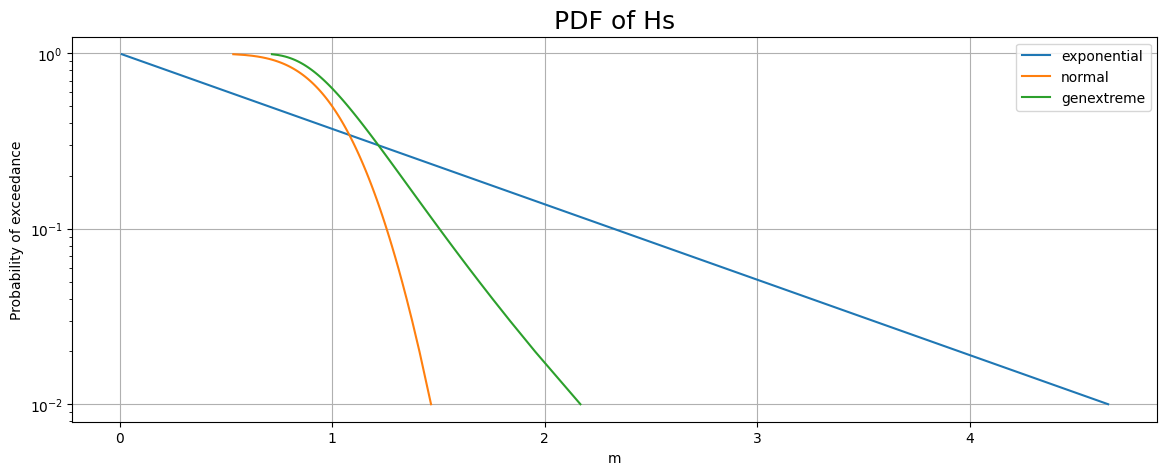

In [7]:
# Create object for a random variable
object_Hs = bivariate.class_emperical.Emperical_data(data_title='Hs', data_units='m')

# Add a distribution to the object
object_Hs.add_distribution(distribution_name= 'exponential',
                            rv_continous_frozen= st.expon(loc=0, scale=1.01) )

object_Hs.add_distribution(distribution_name= 'normal',
                            rv_continous_frozen= st.norm(loc=1, scale=0.2) )

# Add extreme value distribution
object_Hs.add_distribution(distribution_name= 'genextreme',
                            rv_continous_frozen= st.genextreme(c=-0.1, loc=1, scale=0.2))
# Plot the distributions
object_Hs.plot_distributions(log_scale=True)

In [8]:
# Determine the random variables 
Hs = st.expon(loc=1, scale=0.2)           # Significant wave height
u = st.expon(loc=10, scale=1.0663)           # Wind speed
h_offshore = st.norm(loc=4, scale=0.4)      # Water level offshore
Z_bed = st.norm(loc=1, scale=0.1)         # Average bed level over the fetch length

### B.1 Sampling with Monte Carlo

In [23]:
# Generate random samples
n = 100000  # Number of samples

# Generate random samples
Hs_samples = Hs.rvs(size = n)
u_samples = u.rvs(size = n)
h_offshore_samples = h_offshore.rvs(size = n)
Z_bed_samples = Z_bed.rvs(size = n)


In [24]:
def total_water_level_at_dike(Hs, u, h_offshore, Z_bed, alpha=20, F=10000, C2 = 4.0e-6, d_average=None, Ru2=None, S=None):
    """
    This function calculates the seperate parts that sum up to total water level at the dike

    Parameters
    ----------
    Hs : float
        [m] Significant wave height
    alpha : float
        [degrees] Angle of the slope of the toe of dike
    u : float
        [m/s] Wind speed
    d : float
        [m] Average depth over fetch length
    F : float
        [m] Fetch length
    h_offshore : float
        [m] Offshore water level
    Zbed : float
        [m] Bed level at the toe of the dike
    
    Returns
    -------
    TWL_sample : 3D array
        [m] Total water level at the dike, consisting of run-up level, wind set-up and average water depth
    
    """
    # Calculate average water depth over fetch length
    if d_average is None:
        d_average = h_offshore - Z_bed
    elif d_average is not None:
        d_average = np.ones(len(Hs))*d_average
    
    # Calculate wind set-up
    if S is None:
        S = wind_set_up(u,d_average,F, C2)
    elif S is not None:
        S = np.ones(len(Hs))*S
        
    # Calculate run-up level
    if Ru2 is None:
        Ru2 = run_up_level(Hs,alpha)
    elif Ru2 is not None:
        Ru2 = np.ones(len(Hs))*Ru2
    

    # Combine the samples into an array that allows for statistical analysis
    TWL_sample = np.array([Ru2, S, d_average]).T
    return TWL_sample

In [25]:
# Calculate TWL samples
TWL_samples = total_water_level_at_dike(Hs_samples, u_samples, h_offshore_samples, Z_bed_samples)
# Output is a 3D array with the following structure: [Ru2, S, d_average]

In [26]:
def maximum_waterlevel(Ru2, S,d_average):
    h_max = 10
    function = (Ru2 + S + d_average - h_max >= 0)
    return function

#### C.1. Visualising and calculating failure probability in 2D, fixated on one variable

In [27]:
# Fixate S at 2 m and calculate the TWL samples
TWL_samples_fixate_S = total_water_level_at_dike(Hs_samples, u_samples, h_offshore_samples, Z_bed_samples, S=2)
# Extract the Ru2 and d_average samples, since S is fixated and will be in the limit state function
TWL_samples_fixate_S = TWL_samples_fixate_S[:,[0,2]]

# Define new limit state function
def maximum_waterlevel_fixate_S(Ru2, d_average):
    h_max = 10
    function = (Ru2 + 2 + d_average - h_max >= 0)
    return function

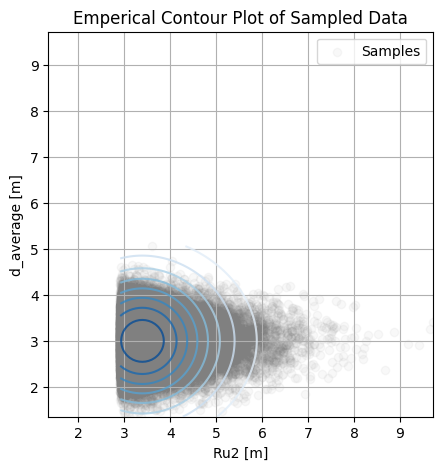

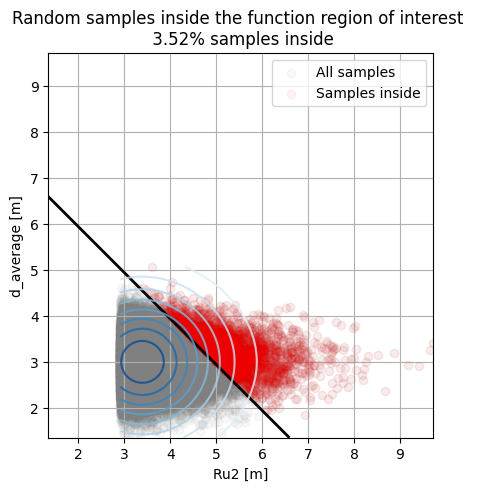

In [28]:
LSF_class_fixate_S = bivariate.class_copula.Region_of_interest(random_samples=TWL_samples_fixate_S, labels = ['Ru2 [m]', 'd_average [m]'])

# Plot the emperical contours of the random samples
LSF_class_fixate_S.plot_emperical_contours(bandwidth=1, equal_axis=True)

# Assign the function to the class instance
LSF_class_fixate_S.function = maximum_waterlevel_fixate_S

# Calculate the probability of failure
LSF_class_fixate_S.inside_function()

# Plot the points inside the region of interest
LSF_class_fixate_S.plot_inside_function(equal_axis=True);




### C.2. Fixate Ru2 

In [29]:
# Fixate S at 2 m and calculate the TWL samples
Ru2_fixed = 1 # m
TWL_samples_fixate_Ru2 = total_water_level_at_dike(Hs_samples, u_samples, h_offshore_samples, Z_bed_samples, Ru2=Ru2_fixed)
# Extract the Ru2 and d_average samples, since S is fixated and will be in the limit state function
TWL_samples_fixate_Ru2 = TWL_samples_fixate_Ru2[:,[1,2]]

# Define new limit state function
def maximum_waterlevel_fixate_Ru2(S, d_average):
    h_max = 10
    function = (Ru2_fixed + S + d_average - h_max >= 0)
    return function

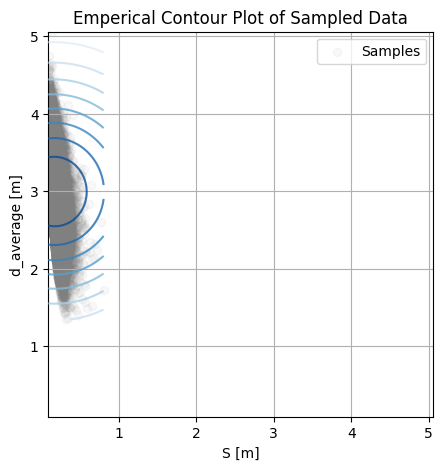

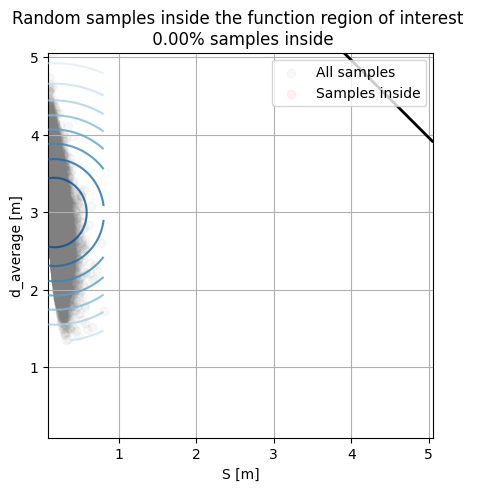

In [30]:
LSF_class_fixate_Ru2 = bivariate.class_copula.Region_of_interest(random_samples=TWL_samples_fixate_Ru2, labels = ['S [m]', 'd_average [m]'])

# Plot the emperical contours of the random samples
LSF_class_fixate_Ru2.plot_emperical_contours(bandwidth=1, equal_axis=True)

# Assign the function to the class instance
LSF_class_fixate_Ru2.function = maximum_waterlevel_fixate_Ru2

# Calculate the probability of failure
LSF_class_fixate_Ru2.inside_function()

# Plot the points inside the region of interest
LSF_class_fixate_Ru2.plot_inside_function(equal_axis=True);



### C.3 fixate d_average_fetch


In [31]:
# Fixate d_average at 3 m and calculate the TWL samples
d_average_fixed = 3 # m
TwL_samples_fixate_d_average = total_water_level_at_dike(Hs_samples, u_samples, h_offshore_samples, Z_bed_samples, d_average=d_average_fixed)

# Extract the Ru2 and S, since d_average is fixated and will be in the limit state function
TWL_samples_fixate_d_average = TwL_samples_fixate_d_average[:,[0,1]]

# Define new limit state function
def maximum_waterlevel_fixate_d_average(S, Ru2):
    h_max = 10
    function = (Ru2 + S + d_average_fixed - h_max >= 0)
    return function

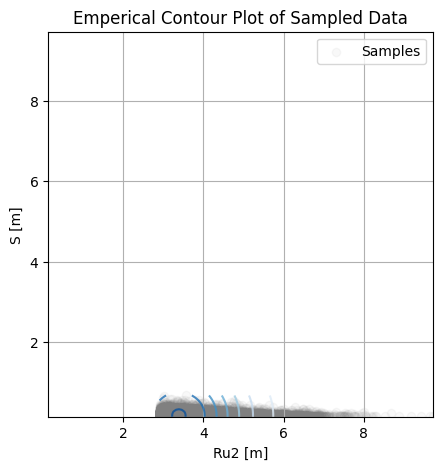

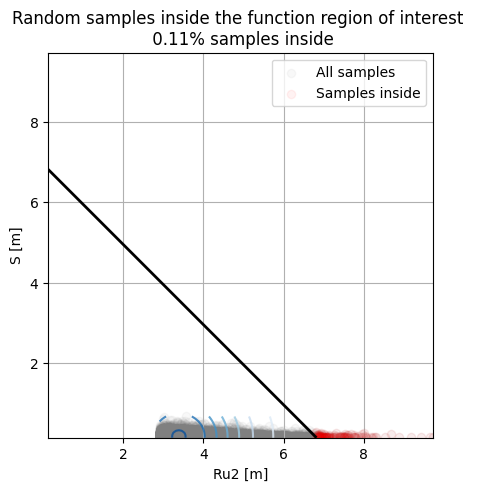

In [32]:
LSF_class_fixate_d_average = bivariate.class_copula.Region_of_interest(random_samples=TWL_samples_fixate_d_average, labels = ['Ru2 [m]', 'S [m]'])

# Plot the emperical contours of the random samples
LSF_class_fixate_d_average.plot_emperical_contours(bandwidth=1, equal_axis=True)

# Assign the function to the class instance
LSF_class_fixate_d_average.function = maximum_waterlevel_fixate_d_average

# Calculate the probability of failure
LSF_class_fixate_d_average.inside_function()

# Plot the points inside the region of interest
LSF_class_fixate_d_average.plot_inside_function(equal_axis=True);


### E. OpenTurns


In [33]:
# Determine the random variables 
Hs_OT = ot.Exponential(2.0309)     # Significant wave height
u_OT = ot.Exponential(2.0663)      # Wind speed


h_offshore_OT = ot.Normal(2, 0.2)  # Water level offshore
Z_bed_OT = ot.Normal(0.5, 0.1)     # Average bed level over the fetch length
d_average_OT = h_offshore_OT - Z_bed_OT  # Average depth over the fetch length

In [20]:
# Determine myLSF
def myLSF(x):
    ''' 
    Vectorized limit-state function.

    Arguments:
    x: vector. x=[Hs, u, h_offshore, Z_bed]. 
    '''
    
    
    # Height of the dike, referenced from the bed level
    z_dike = 10


    g = [z_dike - total_water_level_at_dike(Hs = x[0],alpha = 30, u = x[1], F = 3000, d_average = x[2])]
    return g

In [21]:
from component_reliability import Case_Study_Compontent_Reliability_Tools

In [22]:
Case_Study_Compontent_Reliability_Tools.run_FORM_and_MCS(Hs_OT, u_OT, d_average_OT, myLSF, mc_size = 10000)

TypeError: total_water_level_at_dike() missing 2 required positional arguments: 'h_offshore' and 'Z_bed'

RuntimeError: InternalException : Python exception: TypeError: total_water_level_at_dike() missing 2 required positional arguments: 'h_offshore' and 'Z_bed'